In [1]:
import torch
import os

# Get the current path of the notebook
notebook_path = os.getcwd()

# Construct the path to the directory containing 'fit'
parent_path = os.path.join(notebook_path, '..')
os.chdir(parent_path)
import sys
# Add this parent directory to the system path
sys.path.insert(0, parent_path)
from fit.fit_jet_fm import FM
import pytorch_lightning as pl
import torch
# from utils.dataloader_jetnet import PointCloudDataloader
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from utils.helpers import get_hists, mass
# from utils.dataloader_jetnet import PointCloudDataloader
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, FuncFormatter



/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/late

{'batch_size': 128, 'dropout': 0.0, 'dataset': 'jet', 'freq': 1, 'gan': 'lsgan', 'heads_gen': 16, 'heads': 16, 'hidden_gen': 48, 'hidden': 64, 'l_dim_gen': 16, 'l_dim': 16, 'lambda_gp': 10, 'lr': 0.0001, 'L2': False, 'max_epochs': 2000, 'max': True, 'mean_field_loss': False, 'model': 'MDMA', 'name': 'jet', 'num_layers_gen': 7, 'num_layers': 2, 'opt': 'Adam', 'stop_mean': True, 'weightdecay': 0.0, 'parton': 't', 'n_dim': 3, 'n_part': 150, 'gp': False, 'glu': False, 'gp_weight': 0.1, 'N': 1, 'fid': False, 'cond_dim': 1, 'weightnorm': True, 'spectralnorm': False, 'cloudnorm': False, 'cloudnormgen': False, 'bins': [100, 100, 100, 100], 'noise': False, 'pretrain': False, 'sampler': False, 'amp': False, 'num_batches': 973}


/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cf ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_652/1057788044.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


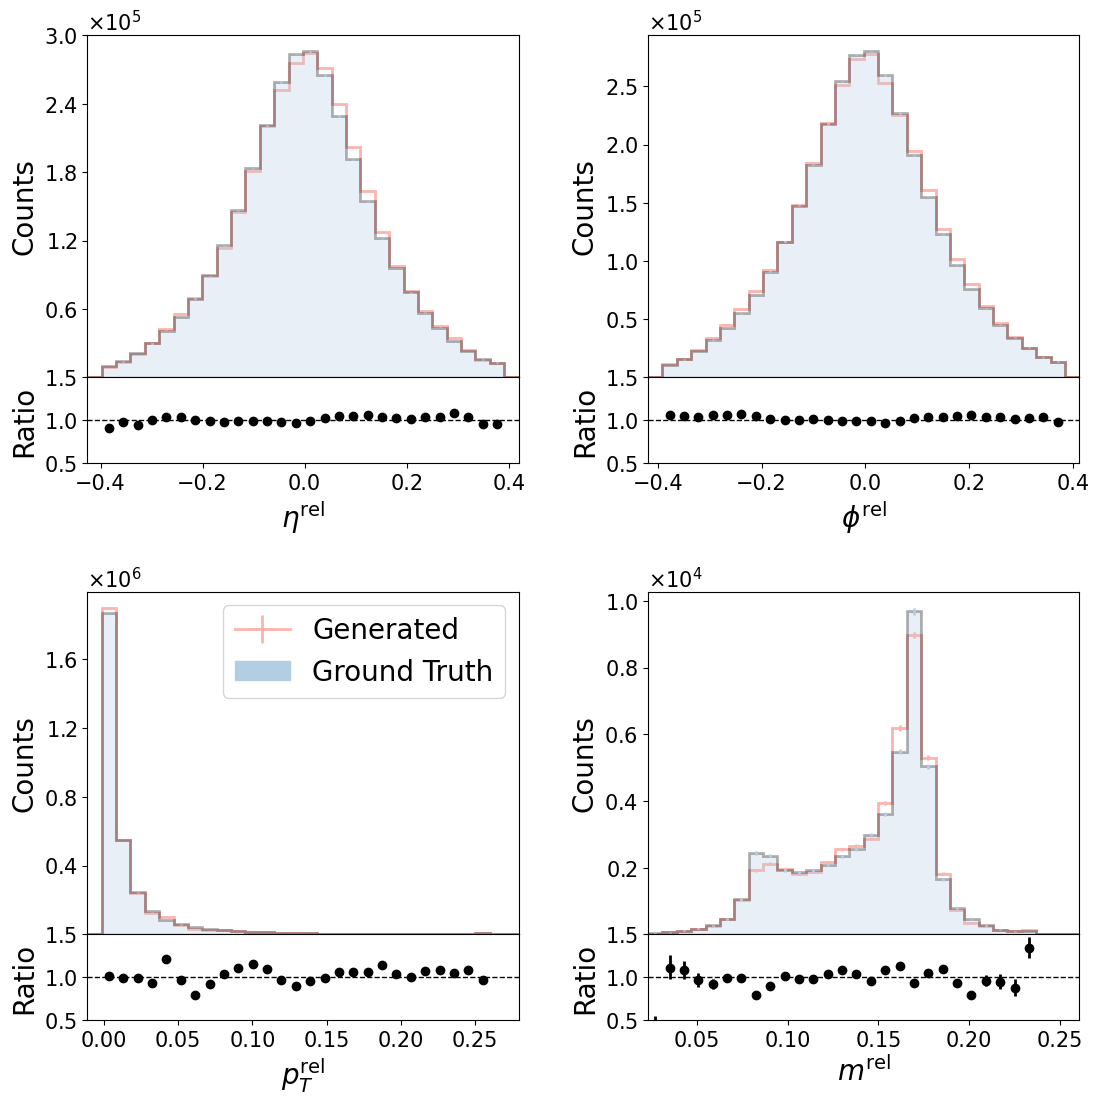

In [5]:
from jetnet.evaluation import w1m
def create_mask(n, size=30):
    # Ensure n is a 1D tensor
    n = n.flatten()

    # Create a range tensor [0, 1, 2, ..., size-1]
    range_tensor = torch.arange(size).unsqueeze(0)

    # Compare range_tensor with n to create the mask
    mask = range_tensor >= n.unsqueeze(1)

    return mask
def fit_kde(n,m,n_max=30):

    from sklearn.neighbors import KernelDensity
    kde=KernelDensity(bandwidth="scott").fit(n.unsqueeze(1).numpy())
    nhat=kde.sample(100000)
    nhat=nhat[nhat<n_max+1]
    mass_distributions = {int(i):m[n==i] for i in n.unique()}
    mass_kdes = {int(i):KernelDensity(bandwidth=1e-3).fit(mass_distributions[i].unsqueeze(1).numpy()) for i in mass_distributions.keys()}


    return kde,mass_kdes
def sample_kde(n,n_kde,m_kde=False):
    #fit kde
    nhat=n_kde.sample(n)
    np.random.shuffle(nhat)
    if m_kde:
        nhat_hist,bins=np.histogram(nhat+0.01,bins=np.arange(0,31),density=False)
        nhat_hist,bins=torch.tensor(nhat_hist),torch.tensor(bins)
        nhat_hist,bins=nhat_hist[nhat_hist>0],bins[1:][nhat_hist>0]

        n_dict={int(i):j for i,j in zip(bins,nhat_hist)}
        ms=[torch.from_numpy(m_kde[int(i)].sample(n_dict[int(i)])) for i in bins]
        mhat=torch.cat(ms).numpy()
        np.random.shuffle(mhat)

        return torch.from_numpy(nhat),torch.from_numpy(mhat)
    else:
        return nhat

def setup_model_with_data(model, data_module, config):
    """
    Sets up the model with the data module and configuration parameters.

    :param model: The model to be set up.
    :param data_module: The data module used for training and validation.
    :param config: Configuration dictionary.
    """
    model.bins = [100, 100, 100, 100]
    model.n_dim = 3
    model.scaler = data_module.scaler
    model.w1m_best = 0.01
    model.min_pt = data_module.min_pt
    model.max_pt = data_module.max_pt

    # Calculate the minimum and maximum values from the training data
    mins, maxs, n_counts = calculate_data_bounds(data_module.train_dataloader(), config["n_dim"])
    model.maxs = maxs.cuda().reshape(-1)
    model.mins = mins.cuda().reshape(-1)
    model.avg_n = torch.cat(n_counts, dim=0).float().cuda().mean()
    if hasattr(model,"gen_net"):
        model.gen_net.avg_n =model.avg_n
    # Additional model settings

    model.scaler = model.scaler.to("cuda")
    model.scaler.std = model.scaler.std.cuda()
    model.scaled_mins = torch.tensor(data_module.mins).cuda()[:3]
    model.scaled_maxs = torch.tensor(data_module.maxs).cuda()[:3]
    print(model.scaled_mins, model.scaled_maxs)

def calculate_data_bounds(dataloader, n_dim):
    """
    Calculates the minimum and maximum values across the dimensions from the dataloader.

    :param dataloader: The dataloader to process.
    :param n_dim: Number of dimensions.
    :return: Tuple of minimum values, maximum values, and count of non-masked data points.
    """
    mins = torch.ones(n_dim).unsqueeze(0)
    maxs = torch.ones(n_dim).unsqueeze(0)
    n_counts = []

    for data in dataloader:
        non_masked_data = data[0][~data[1]]
        mins = torch.min(torch.cat((mins, non_masked_data.min(0, keepdim=True)[0]), dim=0), dim=0)[0].unsqueeze(0)
        maxs = torch.max(torch.cat((maxs, non_masked_data.max(0, keepdim=True)[0]), dim=0), dim=0)[0].unsqueeze(0)
        n_counts.append((~data[1]).sum(1))

    return mins, maxs, n_counts

def distance_corr(var_1,var_2,power=1):
    """var_1: First variable to decorrelate (eg mass)
    var_2: Second variable to decorrelate (eg classifier output)
    normedweight: Per-example weight. Sum of weights should add up to N (where N is the number of examples)
    power: Exponent used in calculating the distance correlation

    va1_1, var_2 and normedweight should all be 1D torch tensors with the same number of entries

    Usage: Add to your loss function. total_loss = BCE_loss + lambda * distance_corr
    """

    xx = var_1.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))
    yy = var_1.repeat(len(var_1),1).view(len(var_1),len(var_1))
    amat = (xx-yy).abs()

    xx = var_2.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))
    yy = var_2.repeat(len(var_2),1).view(len(var_2),len(var_2))
    bmat = (xx-yy).abs()

    amatavg = torch.mean(amat,dim=1)
    Amat=amat-amatavg.repeat(len(var_1),1).view(len(var_1),len(var_1))\
        -amatavg.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))\
        +torch.mean(amatavg)

    bmatavg = torch.mean(bmat,dim=1)
    Bmat=bmat-bmatavg.repeat(len(var_2),1).view(len(var_2),len(var_2))\
        -bmatavg.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))\
        +torch.mean(bmatavg)

    ABavg = torch.mean(Amat*Bmat,dim=1)
    AAavg = torch.mean(Amat*Amat,dim=1)
    BBavg = torch.mean(Bmat*Bmat,dim=1)

    if(power==1):
        dCorr=(torch.mean(ABavg))/torch.sqrt((torch.mean(AAavg)*torch.mean(BBavg)))
    elif(power==2):
        dCorr=(torch.mean(ABavg))**2/(torch.mean(AAavg)*torch.mean(BBavg))
    else:
        dCorr=((torch.mean(ABavg))/torch.sqrt((torch.mean(AAavg)*torch.mean(BBavg))))**power

    return dCorr


def create_distance_corr_matrix(data):
    num_vars = data.shape[1]
    corr_matrix = np.zeros((num_vars, num_vars))
    for i in range(num_vars):
        for j in range(num_vars):
            corr_matrix[i, j] = distance_corr(data[:, i], data[:, j]).detach().cpu().numpy()

    return corr_matrix


def one_digit_formatter(x, pos):
    return f'{x:.1e}'










# from utils.dataloader_jetnet import PointCloudDataloader

FONTSIZE=20
class PlottingThesis:
    def __init__(self, step=None, logger=None, weight=1):
        self.step = step
        self.weight = weight
        self.fig_size1 = [6.4, 6.4]
        self.fig_size2 = [2 * 6.4,2 * 6.4]
        self.fig_size3 = [3 * 6.4, 6.4]
        self.fig_size4 = [4 * 6.4, 6.4]
        self.alpha = 0.3
        #sns.set_theme(style="whitegrid")
        self.cmap = sns.color_palette("Pastel1")
        sns.set_palette("Pastel1")
        self.logger = logger
        mpl.rcParams['lines.linewidth'] = 2
        plt.rcParams['xtick.labelsize'] = 15  # for x-axis tick labels
        plt.rcParams['ytick.labelsize'] = 15  #
        font = { "size": 20}#"family": "normal",
        mpl.rc("font", **font)
        mpl.rc('lines', linewidth=2)

    def plot_ratio(self, h_real, h_fake, weighted, leg=-1, model_name=""):
        fig = plt.figure(figsize=self.fig_size2)


            # Main plot

        # Plot variables and their names
        variables = ["eta", "phi", "pt", "m"]
        names = [r"$\eta^{\mathrm{rel}}$", r"$\phi^{\mathrm{rel}}$", r"$p_T^{\mathrm{rel}}$", r"$m^{\mathrm{rel}}$"]

        outer_gs = gridspec.GridSpec(2, 2, figure=fig,hspace=0.3,wspace=.3)

        for k, (variable, name) in enumerate(zip(variables, names)):
            inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[k],
                                                        height_ratios=[4, 1], hspace=0
                                                        )

            # Create the main and ratio axes within the nested grid
            ax_main = fig.add_subplot(inner_gs[0])
            ax_ratio = fig.add_subplot(inner_gs[1], sharex=ax_main)
            ax_main.tick_params(axis='x', which='both', length=0, labelbottom=False)


            # Plotting logic
            h_fake[k].plot_ratio(
                h_real[k],
                ax_dict={"main_ax": ax_main, "ratio_ax": ax_ratio},
                rp_ylabel="Ratio",
                bar_="blue",
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line"
            )
            ax_ratio.set_xlabel(name, fontsize=FONTSIZE)
            ax_main.set_ylabel("Counts", fontsize=FONTSIZE)
            ax_ratio.set_ylabel("Ratio", fontsize=FONTSIZE)
            ax_main.get_legend().remove()
            ax_ratio.set_ylim(0.5, 1.5)
            ax_main.set_xlabel("")

            ax_main.patches[1].set_fill(True)
            ax_main.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3), useMathText=True)
            ax_ratio.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3), useMathText=True)

            locator=MaxNLocator( nbins=6, prune="both")
            ax_main.yaxis.set_major_locator(locator)
            ax_main.patches[1].set_fc(sns.color_palette()[1])
            ax_main.patches[1].set_edgecolor("black")
            ax_main.patches[1].set_linewidth(2)
            ax_main.patches[1].set_alpha(self.alpha)
            ax_main.patches[0].set_lw(2)
            ax_ratio.set_xlim(ax_main.get_xlim())
            if k==2:
                self._adjust_legend(ax_main, leg)


        plt.tight_layout()
        plt.savefig(f"plots/{model_name}_jetnet.pdf", format="pdf")
        plt.show()
        plt.close()

    def plot_corr(self, real, fake, model, leg=-1, disco=False):
        for disco in [False]:
            for name, data in zip(["Ground Truth", "Generated"], [real, fake]):
                if name=="Ground Truth":
                    lims = self._compute_correlation_limits(data, name, disco)

                for feature_idx, feature in enumerate([r"eta", r"phi", r"p_T"]):
                    correlation_matrix = self._compute_correlation_matrix(data[:, :, feature_idx], disco)
                    np.fill_diagonal(correlation_matrix, np.nan)
                    self._plot_heatmap(correlation_matrix, lims[feature_idx], feature, name, model, disco)

    # Additional helper methods for plot_corr and plot_ratio

    def _compute_correlation_matrix(self, tensor, disco=False):
        # Compute the correlation matrix
        if disco:
            return create_distance_corr_matrix(torch.from_numpy(tensor)[:5000])
        else:
            return np.corrcoef(tensor, rowvar=False)

    def _compute_correlation_limits(self, data, name, disco):
        # Compute limits for correlation plots
        lims = []
        for feature_idx in range(3):
            correlation_matrix = self._compute_correlation_matrix(data[:, :, feature_idx], disco)
            non_ones = correlation_matrix[correlation_matrix <= 0.99]
            if name == "Ground Truth":
                lims.append((non_ones.min(), non_ones.max()))
        return lims

    def _plot_heatmap(self, matrix, limits, feature, name, model, disco):
        fig, ax = plt.subplots(1, 1, figsize=(8, 6.4))
        sns.heatmap(matrix,ax=ax, cmap='coolwarm', cbar=False, vmin=limits[0], vmax=limits[1])

        ax.set_xticks([0.5,9.5,19.5,29.5],labels=[1,10,20,30], rotation=0,fontsize=FONTSIZE+5)
        ax.set_yticks([0.5,9.5,19.5,29.5],labels=[1,10,20,30],rotation=0,fontsize=FONTSIZE+5)
        ax.set_xlabel("Particles",fontsize=FONTSIZE+10)
        ax.set_ylabel("Particles",fontsize=FONTSIZE+10)
        #cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        plt.tight_layout()
        cbar=fig.colorbar(ax.collections[0])
        cbar.ax.tick_params(labelsize=FONTSIZE+5)
        disco_suffix = "_disco" if disco else ""
        if name == "Ground Truth":
            plt.savefig(f"plots/{feature}_corr_{name}{disco_suffix}.pdf", format="pdf")
        else:
            plt.savefig(f"plots/{feature}_corr_{name}{disco_suffix}_{model}.pdf", format="pdf")
        plt.show()

    def _adjust_legend(self, ax, leg):
        # Adjust the legend on the plot
        if leg >= 0:
            ax.legend(loc="best", fontsize=FONTSIZE)
            handles, labels = ax.get_legend_handles_labels()
            handles[1] = mpatches.Patch(color=sns.color_palette()[1], label="The red data")
            ax.legend(handles, labels)
def make_plots(model_name, disco=False):
    import os

    ckptdir = "/ckpts/"

    ckpt = "{}.ckpt".format(model_name)


    # ckpt = "t_{}.ckpt".format(model_name)
    ckpt = f"/home/kaechben/MDMACalo/ckpts/{model_name}.ckpt"

    # Load state dictionary from checkpoint
    state_dict = torch.load(ckpt)
    import yaml

    boxcox=model_name.find("_std")==-1
    config = state_dict["hyper_parameters"]
    # config["sampler"]=True
    # config["exact"]=True
    print(config)
    config["ckpt"]=None
    # Choose the model class based on the model name
    config["boxcox"]=   boxcox

    if boxcox:
        from utils.dataloader_jetnet import PointCloudDataloader
    else:
        from utils.dataloader_jetnet_std import PointCloudDataloader
    data_module = PointCloudDataloader(**config)
    data_module.setup("fit")

    if model_name.find("fm")==-1:
            from fit.fit import MDMA
            model=MDMA.load_from_checkpoint(ckpt,strict=False,boxcox=boxcox)
            model.gen_net.avg_n = data_module.avg_n
            model.mins=data_module.std_mins
            model.maxs=data_module.std_maxs

    else:
        model=FM.load_from_checkpoint(ckpt,boxcox=boxcox)
    model.w1m_best = 0.01
    config["batch_size"]=512
    # Initialize data module and set up model
    model.scaler=data_module.scaler.to("cuda")
    model.scaled_mins = torch.tensor(data_module.mins).cuda()[:3]
    model.scaled_maxs = torch.tensor(data_module.maxs).cuda()[:3]
    model.batch=[]
    model.n_dim=3
    model.masks=[]
    model.fake=[]
    model.conds=[]
    model=model.cuda()
    model.name="jet"
    model.load_datamodule(data_module)
    trainer = pl.Trainer(
            devices=1,
            precision=32,
            accelerator="gpu",
            gradient_clip_val=0.5 if config["model"] == "FM" else None,
            log_every_n_steps=100,
            max_epochs=config["max_epochs"],
            val_check_interval=10000 if (config["dataset"] == "calo") and config["model"]=="FM" else 5000 if config["dataset"]=="calo" else None,
            check_val_every_n_epoch=250 if  (config["ckpt"]=="" and config["dataset"]=="jet") else 100 if (config["dataset"] == "jet") else None  ,
            num_sanity_val_steps=1,

            enable_progress_bar=False,
            default_root_dir="/gpfs/dust/maxwell/user/{}/{}".format(
                os.environ["USER"], config["dataset"]
            ),
        )
    trainer.test(model=model,dataloaders=data_module.test_dataloader())
    #plotter.plot_corr(true.numpy(), fake.numpy(), model_name, disco=disco,leg=-1)
    true = torch.cat([torch.nn.functional.pad(batch, (0, 0, 0, model.hparams.n_part - batch.size(1))) for batch in model.batch],dim=0) if model.hparams.max else torch.cat(model.batch)
    fake= torch.cat([torch.nn.functional.pad(batch, (0, 0, 0, model.hparams.n_part - batch.size(1))) for batch in model.fake],dim=0) if model.hparams.max else torch.cat(model.fake)
    sorted_indices = torch.argsort(fake[:,:,2], dim=1, descending=True)

    fake = torch.gather(fake, 1, sorted_indices.unsqueeze(-1).expand(-1, -1, fake.shape[2]))
    fake = torch.clamp(fake, min=true.reshape(-1, 3).min(), max=true.reshape(-1, 3).max())
    m_f, m_t = mass(fake), mass(true)

    # Apply clamping based on quantiles
    mins = torch.quantile(true.reshape(-1, 3), 0.001, dim=0)
    maxs = torch.quantile(true.reshape(-1, 3), 0.999, dim=0)
    fake = torch.clamp(fake, min=mins, max=maxs)
    true = torch.clamp(true, min=mins, max=maxs)
    m_f = torch.clamp(m_f, min=torch.quantile(m_t, 0.001), max=torch.quantile(m_t, 0.999))
    m_t = torch.clamp(m_t, min=torch.quantile(m_t, 0.001), max=torch.quantile(m_t, 0.999))
    mins=torch.cat([mins,torch.tensor([torch.quantile(m_t, 0.001)])])-0.01
    maxs=torch.cat([maxs,torch.tensor([torch.quantile(m_t, 0.999)])])*1.01

    # Prepare histograms
    hists=get_hists([30,30,30,30],mins*1.1,maxs*1.1,calo=model.name=="calo")


    # Fill histograms
    for var in range(3):
        hists["hists_real"][var].fill(true.reshape(-1, 3)[(true.reshape(-1, 3) != 0).all(1)][:, var].cpu().numpy())
        hists["hists_fake"][var].fill(fake.reshape(-1, 3)[(fake.reshape(-1, 3) != 0).all(1)][:, var].cpu().numpy())


    hists["hists_real"][3].fill(m_t.cpu().numpy())
    hists["hists_fake"][3].fill(m_f.cpu().numpy())

    # Plotting
    plotter = PlottingThesis()
    plotter.plot_ratio(hists["hists_real"], hists["hists_fake"], weighted=False, leg=2, model_name=model_name)
    return model

for model_name in ["mdma_jet_std"]:#
    model=make_plots(model_name)


(0.0013867841726653278, 0.00017177067881935675)


/tmp/ipykernel_652/1057788044.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


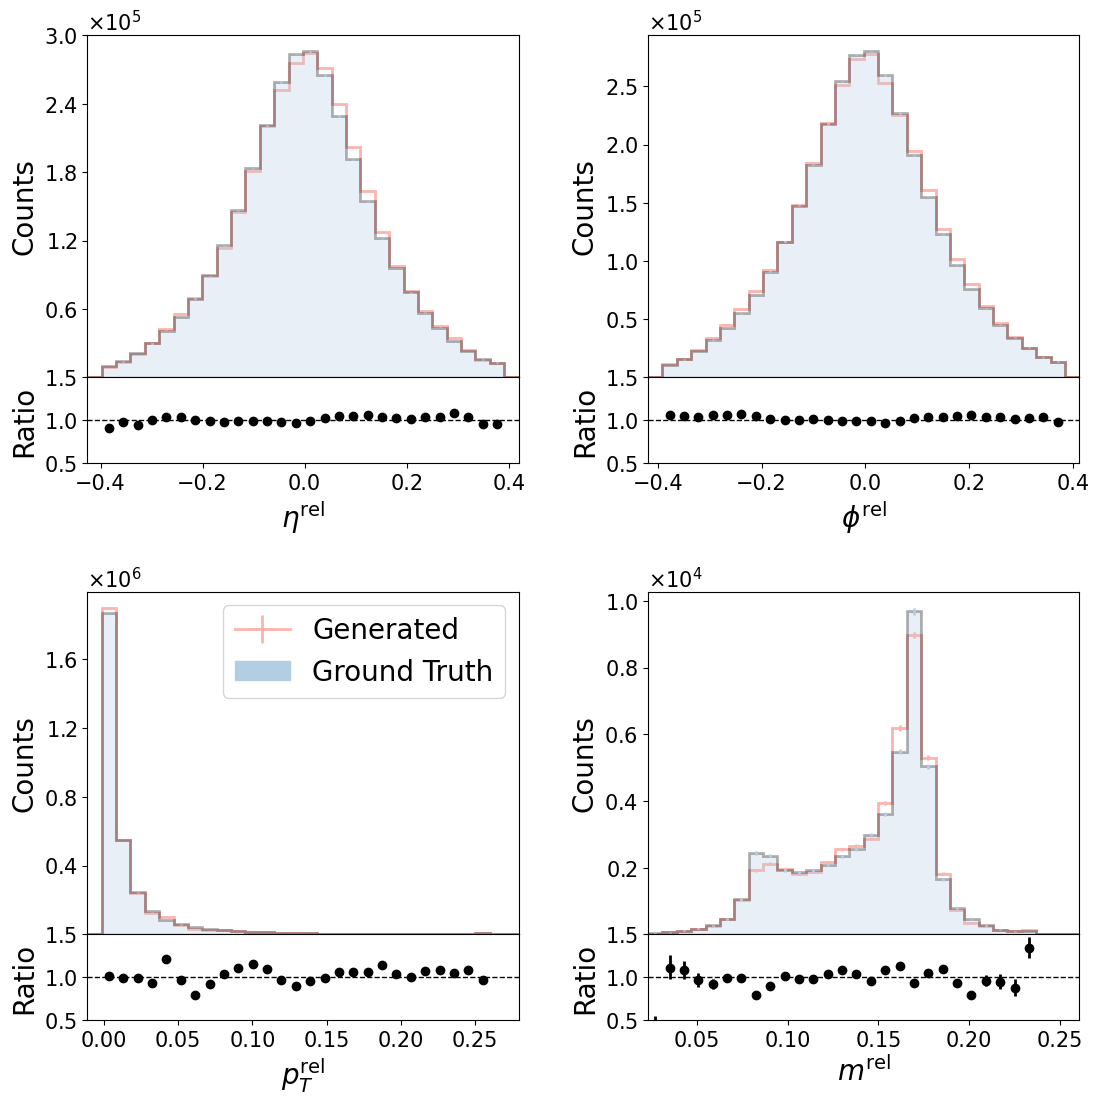

In [6]:
true = torch.cat([torch.nn.functional.pad(batch, (0, 0, 0, 150 - batch.size(1))) for batch in model.batch],dim=0)

fake= torch.cat([torch.nn.functional.pad(batch, (0, 0, 0, 150 - batch.size(1))) for batch in model.fake],dim=0)
# fake = torch.cat(fake)
# true = torch.cat(real)
w1m_=w1m(fake,true)
print(w1m_)
sorted_indices = torch.argsort(fake[:,:,2], dim=1, descending=True)
fake = torch.gather(fake, 1, sorted_indices.unsqueeze(-1).expand(-1, -1, fake.shape[2]))
fake = torch.clamp(fake, min=true.reshape(-1, 3).min(), max=true.reshape(-1, 3).max())
m_f, m_t = mass(fake), mass(true)

# Apply clamping based on quantiles
mins = torch.quantile(true.reshape(-1, 3), 0.001, dim=0)
maxs = torch.quantile(true.reshape(-1, 3), 0.999, dim=0)
fake = torch.clamp(fake, min=mins, max=maxs)
true = torch.clamp(true, min=mins, max=maxs)
m_f = torch.clamp(m_f, min=torch.quantile(m_t, 0.001), max=torch.quantile(m_t, 0.999))
m_t = torch.clamp(m_t, min=torch.quantile(m_t, 0.001), max=torch.quantile(m_t, 0.999))
mins=torch.cat([mins,torch.tensor([torch.quantile(m_t, 0.001)])])-0.01
maxs=torch.cat([maxs,torch.tensor([torch.quantile(m_t, 0.999)])])*1.01

# Prepare histograms
hists=get_hists([30,30,30,30],mins*1.1,maxs*1.1,calo=model.name=="calo")


# Fill histograms
for var in range(3):
    hists["hists_real"][var].fill(true.reshape(-1, 3)[(true.reshape(-1, 3) != 0).all(1)][:, var].cpu().numpy())
    hists["hists_fake"][var].fill(fake.reshape(-1, 3)[(fake.reshape(-1, 3) != 0).all(1)][:, var].cpu().numpy())


hists["hists_real"][3].fill(m_t.cpu().numpy())
hists["hists_fake"][3].fill(m_f.cpu().numpy())

# Plotting
plotter = PlottingThesis()
plotter.plot_ratio(hists["hists_real"], hists["hists_fake"], weighted=False, leg=2, model_name=model_name)
    #plotter.plot_corr(true.numpy(), fake.numpy(), model_name, disco=disco,leg=-1)



In [5]:
len(true)

25600

In [13]:
ckpt="ckpts/mdma_jet.ckpt"

MDMA.load_from_checkpoint(ckpt,)
with torch.no_

{'L2': False, 'N': 1, 'amp': False, 'batch_size': 128, 'bins': [100, 100, 100, 100], 'ckpt': './ckpts/t_mdma.ckpt', 'cloudnorm': False, 'cloudnormgen': False, 'cond_dim': 1, 'dataset': 'jet', 'decay': 0.999, 'dropout': 0, 'ema': True, 'ema_start': 50000, 'fid': False, 'freq': 1, 'gan': 'lsgan', 'glu': False, 'gp': False, 'gp_weight': 0.1, 'heads': 16, 'heads_gen': 16, 'hidden': 128, 'hidden_gen': 128, 'l_dim': 16, 'l_dim_gen': 16, 'lambda_gp': 10, 'lr': 0.0001, 'max': True, 'max_epochs': 2000, 'mean_field_loss': True, 'model': 'MDMA', 'n_dim': 3, 'n_part': 150, 'name': 'jet', 'noise': False, 'num_layers': 2, 'num_layers_gen': 7, 'opt': 'AdamW', 'parton': 't', 'pretrain': False, 'sampler': True, 'spectralnorm': False, 'stop_mean': True, 'weightdecay': 0.01, 'weightnorm': True}


MDMA(
  (gen_net): Gen(
    (embbed): Linear(in_features=3, out_features=16, bias=True)
    (encoder): ModuleList(
      (0-6): 7 x Block(
        (fc0): Linear(in_features=16, out_features=128, bias=True)
        (fc1): Linear(in_features=256, out_features=16, bias=True)
        (fc1_cls): Linear(in_features=129, out_features=128, bias=True)
        (fc2_cls): Linear(in_features=128, out_features=16, bias=True)
        (cond_cls): WeightNormalizedLinear (1 -> 128)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (act): LeakyReLU(negative_slope=0.01)
        (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (out): Linear(in_features=16, out_features=3, bias=True)
    (act): LeakyReLU(negative_slope=0.01)
  )
  (dis_net): Disc(
    (embbed): WeightNormalizedLinear (3 -> 16)
    (encoder): ModuleList(
      (0-1): 2 x Block(
        (fc0): WeightNormalizedL

{'batch_size': 256, 'ckpt_flow': './ckpts/t_nflow.ckpt', 'ckpt': '', 'norm': True, 'num_layers': 4, 'fast': False, 'dropout': 0, 'dataset': 'jet', 'heads_gen': 16, 'heads': 16, 'num_heads': 16, 'hidden_gen': 256, 'hidden': 256, 'l_dim_gen': 16, 'l_dim': 16, 'lr': 0.0001, 'mass_loss': False, 'max_epochs': 2000, 'max': False, 'mean_field_loss': True, 'model': 'TNF', 'gan': 'lsgan', 'gp': False, 'freq': 1, 'name': 'jet_tnf', 'num_layers_gen': 4, 'opt': 'AdamW', 'weightdecay': 0.01, 'parton': 't', 'n_dim': 3, 'n_part': 30, 'N': 1, 'noise': False, 'cond_dim': 0, 'bins': [100, 100, 100, 100], 'pretrain': False, 'sampler': True, 'start_swa': False, 'amp': False, 'coupling_layers': 10, 'coupling_hidden': 256, 'spline': True, 'network_layers': 6, 'hidden_features': 256, 'tail_bound': 6, 'num_bins': 8, 'batchnorm': False, 'context_features': 0, 'num_batches': 486}


(array([  4.,   8.,  14.,  40.,  53.,  75., 102., 166., 230., 326., 467.,
        469., 396., 386., 479., 456., 540., 652., 733., 865., 878., 923.,
        796., 530., 261.,  99.,  31.,  13.,   7.,   1.]),
 array([0.01650176, 0.02275386, 0.02900597, 0.03525808, 0.04151018,
        0.04776229, 0.05401439, 0.0602665 , 0.0665186 , 0.07277071,
        0.07902281, 0.08527492, 0.09152702, 0.09777913, 0.10403124,
        0.11028334, 0.11653545, 0.12278755, 0.12903966, 0.13529176,
        0.14154387, 0.14779597, 0.15404808, 0.16030018, 0.16655229,
        0.17280439, 0.1790565 , 0.18530861, 0.19156071, 0.19781282,
        0.20406492]),
 <BarContainer object of 30 artists>)

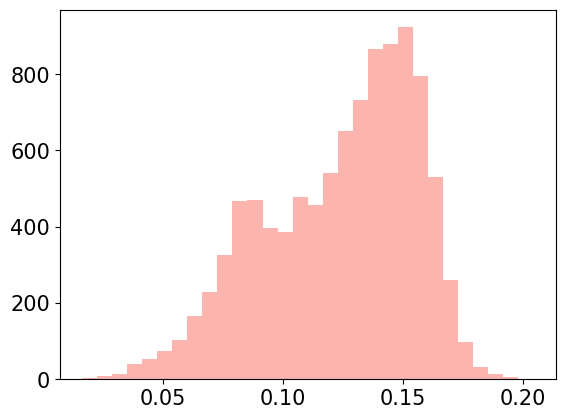

In [13]:
ckpt = torch.load("ckpts/tnf_slow.ckpt")
config = ckpt["hyper_parameters"]
print(config)
data_module = PointCloudDataloader(**config)
data_module.setup("train")



flow = TNFModel(**config).load_from_checkpoint("ckpts/tnf_slow.ckpt",**config)
flow.scaler=data_module.scaler.to("cuda")
flow.scaled_mins=torch.from_numpy(data_module.mins).cuda()
flow.scaled_maxs=torch.from_numpy(data_module.maxs).cuda()
flow.load_datamodule(data_module)
flow.cuda()
data=data_module.train_dataloader().dataset[:10000]
data,mask=data[:,:,:3],data[:,:,-1].bool()
with torch.no_grad():
    data,_=flow.sampleandscale(data.cuda(),mask=mask.cuda(),cond=None,scale=True)
    m=mass(data)
plt.hist(m.cpu().numpy(),bins=30)

In [8]:
with torch.no_grad():
    ckpt=torch.load("./ckpts/t_nflow.ckpt")
ckpt["hyper_parameters"]


{'batch_size': 128,
 'ckpt': False,
 'dropout': 0,
 'dataset': 'jet',
 'hidden_gen': 48,
 'hidden': 64,
 'l_dim_gen': 16,
 'l_dim': 16,
 'lr': 0.0001,
 'mass_loss': False,
 'max_epochs': 2000,
 'max': False,
 'mean_field_loss': True,
 'model': 'NF',
 'name': 'jet_nf',
 'num_layers': 7,
 'opt': 'Adam',
 'weightdecay': 0.0,
 'parton': 't',
 'n_dim': 3,
 'n_part': 30,
 'N': 1,
 'cond_dim': 1,
 'bins': [100, 100, 100, 100],
 'pretrain': False,
 'sampler': True,
 'start_swa': False,
 'amp': False,
 'coupling_layers': 7,
 'coupling_hidden': 128,
 'spline': True,
 'network_layers': 4,
 'hidden_features': 128,
 'tail_bound': 5,
 'num_bins': 8,
 'batchnorm': True,
 'context_features': 0}

In [1]:
import pandas as pd
import numpy as np
import ast
from numpy import array
import re
# Convert string representation of lists back to lists
def convert_str_to_tuple(s):
    # Extract lists from the string using regex
    s=s.replace("\n ","")
    lists = re.findall(r'\[.*?\]', s)
    arrays = [np.array(ast.literal_eval(l)) for l in lists]
    return tuple(arrays)
results=pd.read_csv("bravobenno.csv")
def weighted_mean(x):
        x,w=np.array(x[0]),np.array(x[1])
        weights=1/w**2
        return np.sum(x*weights)/np.sum(weights)
def weighted_std(x):
    w=(1/np.array(x[1]))**2
    sigma=np.sqrt(1/np.sum(w))
    return sigma

def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"
df=results
df["pmm"]=df["w1m"].apply(ast.literal_eval).apply(lambda x:x).apply(weighted_std)
df["w1m"]=df["w1m"].apply(ast.literal_eval).apply(lambda x:x).apply(weighted_mean)
df["pmp"]=df["w1p"].apply(convert_str_to_tuple).apply(lambda x:x).apply(weighted_std)
df["w1p"]=df["w1p"].apply(convert_str_to_tuple).apply(lambda x:x).apply(weighted_mean)
df["pme"]=df["w1efp"].apply(convert_str_to_tuple).apply(lambda x:x).apply(weighted_std)
df["w1efp"]=df["w1efp"].apply(convert_str_to_tuple).apply(lambda x:x).apply(weighted_mean)

df["fpd_std"]=df["fpd"].apply(ast.literal_eval).apply(lambda x:x[1]).apply(np.mean)
df["fpd"]=df["fpd"].apply(ast.literal_eval).apply(lambda x:x[0]).apply(np.mean)
df["kpd_std"]=df["kpd"].apply(ast.literal_eval).apply(lambda x:x[1]).apply(np.mean)
df["kpd"]=df["kpd"].apply(ast.literal_eval).apply(lambda x:x[0]).apply(np.mean)

cols=["name","w1m","w1efp","w1m","pmm","pme","pmp","cov","mmd","fpd","kpd","time","parameters"]
replace_dict={"MPGAN":"MPGAN","t_cpflow":"PF","t_ipflow":"IPF","t_apflow":"APF","t_nflow":"NF","t_ccnflow":"NF(cc)","t_cnflow":"NF(c)","t_tnflow":"TNF","IN":"IN"}
df.loc[:,"model"]=df["model"].apply(lambda x:replace_dict[x])
df=df.set_index("model",drop=True)
df.loc[:,"w1m"]*=1000
df.loc[:,"w1p"]*=1000
df["w1p"]=df["w1p"]
df.loc[:,"w1efp"]*=100000
df["w1efp"]=df["w1efp"]
df.loc[:,"pmm"]*=1000
df.loc[:,"pmp"]*=1000
df.loc[:,"pme"]*=100000
df.loc[:,"fpd"]*=10000
df.loc[:,"fpd_std"]*=10000
df.loc[:,"kpd"]*=10000

df.loc[:,"kpd_std"]*=10000
df.loc[:,"w1m"]=df.apply(lambda x:format_mean_sd(float(x["w1m"]),float(x["pmm"])),axis=1)
df.loc[:,"w1p"]=df.apply(lambda x:format_mean_sd(float(x["w1p"]),float(x["pmp"])),axis=1)
df.loc[:,"w1efp"]=df.apply(lambda x:format_mean_sd(float(x["w1efp"]),float(x["pme"])),axis=1)
df.loc[:,"kpd"]=df.apply(lambda x:format_mean_sd(float(x["kpd"]),float(x["kpd_std"])),axis=1)
df.loc[:,"fpd"]=df.apply(lambda x:format_mean_sd(float(x["fpd"]),float(x["fpd_std"])),axis=1)
df.loc[:,"time"]*=1e6
df.loc[:,"time"]=np.round(df["time"],decimals=1)
order=["PF","IPF","APF","NF","NF(c)","NF(cc)","TNF","MPGAN","IN"]
df=df.loc[order,:]
print(df)
# def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
# print (count_parameters(model.gen_net))
tex=""
for p in ["t"]:
    temp=df
    for col in df.columns:
        if col not in ["w1m","w1p","w1efp","fpd","kpd","time"]:
            continue
        temp_index=temp[col].astype(str).str.replace("$","").str.replace("k","").str.split("\\").str[0].astype(float)
        mins=temp_index==temp_index.drop("IN").min()
        temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
    temp=temp.reset_index()[["model","w1m","w1p","w1efp","kpd","fpd","time"]]
    temp.columns=["model","$W_1^M (\times 10^{3})$","$W_1^P (\times 10^{3})$","$W_1^{EFP}(\times 10^{5})$","$KPD(\times 10^{4})$","$FPD$","Time $\mu s$"]
    text=temp.to_latex(index=False,escape=False)
    parton="Gluon" if p=="g" else "Light Quark" if p=="q" else "Top Quark"
    tex+="\multirow{9}{*}{"+parton+"} & "+text.split("FPD")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("  ","")[:-2]+"\cline{1-8}"
    tex+="\n"
print(tex)


FileNotFoundError: [Errno 2] No such file or directory: 'bravobenno.csv'

In [17]:
results["w1efp"][0]

'(array([0.00025178, 0.00022063, 0.00026026, 0.00043311, 0.00019063]), array([6.04386555e-07, 1.94986961e-06, 2.46654965e-06, 1.54915805e-06,\n       1.93143100e-06]))'